# Zero-Shot Video Classification
 pass a video of choice to [X-CLIP](https://huggingface.co/docs/transformers/model_doc/xclip) and ask X-CLIP to assign probabilities to the provided text description. This model developed by [Ni et al 2022](https://arxiv.org/abs/2208.02816) aims to extend OpenAI's CLIP model that's focused on image-related tasks.

1. You will learn how to load a video from YouTube and do minor processing on the video for X-CLIP
1. Use X-CLIP to assign probabilities to text descriptions

DISCLAIMER: The majority of this notebook's code is borrowed from Hugging Face's Tutorial GitHub Repo, specifically the["Transformers-Tutorials/X-CLIP"](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/X-CLIP/Zero_shot_classify_a_YouTube_video_with_X_CLIP.ipynb) notebook.

 use [pytube](https://pytube.io/en/latest/index.html) to get videos from YouTube and load videos using [decord](https://github.com/dmlc/decord).

In [ ]:
%pip install decord==0.6.0 openai==0.27.8 pytube==15.0.0

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 0.27.7
    Not uninstalling openai at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-25aa8d60-7419-4362-8ed4-5518e93f7af6
    Can't uninstall 'openai'. No files were found to uninstall.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [ ]:
%run ../Includes/pytube_patch

Below, we will load a YouTube video of a piano performance.

`streams.filter` method provides flexible ways for us to filter based on the type of stream that we're interested in. Refer to [documentation here](https://pytube.io/en/latest/user/streams.html#filtering-by-streaming-method).

In [ ]:
from pytube import YouTube

# a video of piano performance
youtube_url = "https://www.youtube.com/watch?v=-xKM3mGt2pE"
yt = YouTube(youtube_url)

streams = yt.streams.filter(file_extension="mp4")
print(streams)

[<Stream: itag="18" mime_type="video/mp4" res="360p" fps="25fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">, <Stream: itag="22" mime_type="video/mp4" res="720p" fps="25fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">, <Stream: itag="137" mime_type="video/mp4" res="1080p" fps="25fps" vcodec="avc1.640028" progressive="False" type="video">, <Stream: itag="136" mime_type="video/mp4" res="720p" fps="25fps" vcodec="avc1.4d401f" progressive="False" type="video">, <Stream: itag="135" mime_type="video/mp4" res="480p" fps="25fps" vcodec="avc1.4d401e" progressive="False" type="video">, <Stream: itag="134" mime_type="video/mp4" res="360p" fps="25fps" vcodec="avc1.4d401e" progressive="False" type="video">, <Stream: itag="133" mime_type="video/mp4" res="240p" fps="25fps" vcodec="avc1.4d4015" progressive="False" type="video">, <Stream: itag="160" mime_type="video/mp4" res="144p" fps="25fps" vcodec="avc1.4d400c" progressive="False" type="video

Let's say that we only are interested in the first part of the video stream. We will download only the third portion and save it to our directory.

In [ ]:
import os

output_dir = os.path.join(DA.paths.working_dir, "video")
file_path = streams[0].download(output_path=output_dir)
file_path

'/dbfs/mnt/dbacademy-users/labuser4574438@vocareum.com/llm-foundation-models/video/Take On Me (MTV Unplugged).mp4'

Recall from the presentation that audio data is often split into chunks. The same applies to videos as well. Below we will split the video into different frames.

`frame_rate` is a common term in video processing to refer to # of pictures taken per second. For audio-only data, it's called `sampling_rate`.

`VideoReader` helps us to access frames directly from the video files. Refer to [documentation here](https://github.com/dmlc/decord#videoreader).

In [ ]:
from decord import VideoReader, cpu
import torch
import numpy as np
from huggingface_hub import hf_hub_download

np.random.seed(42)

# this does in-memory decoding of the video
videoreader = VideoReader(file_path, num_threads=1, ctx=cpu(0))
print("Length of video frames: ", len(videoreader))

def sample_frame_indices(clip_len, frame_sample_rate, seg_len):

    # Since each frame length is 4 seconds, we need to find the total frame length if we want `clip_len` frames
    converted_len = int(clip_len * frame_sample_rate)

    # Get a random frame to end on
    end_idx = np.random.randint(converted_len, seg_len)
    # Find the starting frame, if the frame has length of clip_len
    start_idx = end_idx - converted_len

    # np.linspace returns evenly spaced numbers over a specified interval
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

Length of video frames:  5737


In [ ]:

indices = sample_frame_indices(clip_len= 32,
                               frame_sample_rate=8,
                               seg_len=len(videoreader))
print("Number of frames we will retrieve: ", len(indices))

# `get_batch` allows us to get multiple frames at once
video = videoreader.get_batch(indices).asnumpy()

Number of frames we will retrieve:  32


We will now randomly pick a video frame to inspect.

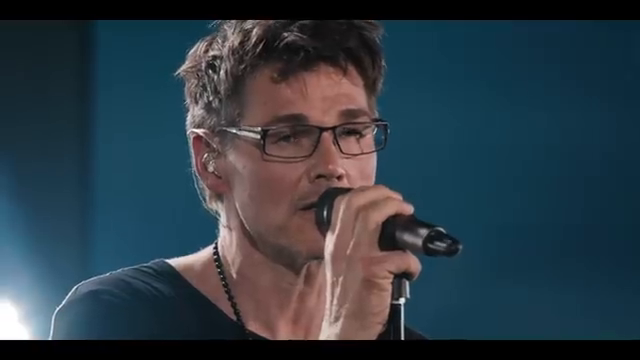

In [ ]:
from PIL import Image

Image.fromarray(video[8])



 now pass in XCLIP model to process our video frames and as our model to assign probabilities to text descriptions to the model.

The model we will use is `microsoft/xclip-base-patch16-zero-shot`.

In [ ]:
# TODO

from transformers import XCLIPProcessor, XCLIPModel

model_name ="microsoft/xclip-base-patch16-zero-shot"
processor = XCLIPProcessor.from_pretrained(model_name)
model = XCLIPModel.from_pretrained(model_name)

`id2label` is found in both `text_config_dict` and `text_config` but with different values. The value `text_config_dict["id2label"]` will be used instead.




 list of three text descriptions and ask the model to assign probabitilies to each of them.

Let's use `text_description_list = ["play piano", "eat sandwich", "play football"]`



In [ ]:
# TODO
import torch

text_description_list = ["play piano", "eat sandwich", "play football"]

inputs = processor(text=text_description_list,
                   videos=video,
                   return_tensors="pt",
                   padding=True)

# forward pass
# we are not going to train the model, hence we specify .no_grad()
with torch.no_grad():
    outputs = model(**inputs)

# we will get probabilities per video frame and calculate the softmax
video_probs = outputs.logits_per_video.softmax(dim=1)
print(dict(zip(text_description_list, video_probs[0])))

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File /databricks/python/lib/python3.10/site-packages/PIL/Image.py:2953, in fromarray(obj, mode)
   2952 try:
-> 2953     mode, rawmode = _fromarray_typemap[typekey]
   2954 except KeyError as e:

KeyError: ((1, 1, 640, 3), '|u1')

The above exception was the direct cause of the following exception:

TypeError                                 Traceback (most recent call last)
File <command-3263905024751179>:6
      2 import torch
      4 text_description_list = ["play piano", "eat sandwich", "play football"]
----> 6 inputs = processor(text=text_description_list, 
      7                    videos=video, 
      8                    return_tensors="pt", 
      9                    padding=True)
     11 # forward pass
     12 # we are not going to train the model, hence we specify .no_grad()
     13 with torch.no_grad():

File /databricks/py

## Using OpenAI's CLIP and Whisper


For this section to work, you need to generate an Open AI key.


In [ ]:

import os

os.environ["OPENAI_API_KEY"] = "<FILL IN>"

In [ ]:
import openai

openai.api_key = os.environ["OPENAI_API_KEY"]

###  Using CLIP

OpenAI's CLIP can help  generate images from provided text.

In [ ]:
image_resp = openai.Image.create(prompt="robots play water balloons, modern painting",
                                 n=1,
                                 size="512x512")
image_resp
displayHTML(image_resp["data"][0]["url"])

You can also use it to assign text caption probabilities based on provided image.

In [ ]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
cat_image = Image.open(requests.get(url, stream=True).raw)
display(cat_image)

In [ ]:
caption_list = ["eating pasta", "cats sleeping"]

inputs = clip_processor(text=caption_list,
                        images=cat_image,
                        return_tensors="pt",
                        padding=True)

clip_outputs = clip_model(**inputs)
# This calculates image-text similarity score
clip_logits_per_image = clip_outputs.logits_per_image

# Use softmax to get caption probabilities
image_probs = clip_logits_per_image.softmax(dim=1)
print(dict(zip(caption_list, image_probs[0])))

### Using Whisper

OpenAI's Whisper Automatic Speech Recognition system

In [ ]:
import requests

# URL of the sample audio file (in this case, a simple English sentence)
audio_url = "https://audio-samples.github.io/samples/mp3/blizzard_primed/sample-1.mp3"

# Download the audio file
response = requests.get(audio_url)

audio_directory = os.path.join(DA.paths.working_dir, "sample_audio.mp3")
# Save the audio file to disk
with open(audio_directory, "wb") as audio_file:
    audio_file.write(response.content)

print("Sample audio file 'sample_audio.wav' downloaded.")

In [ ]:
audio_file = open(audio_directory, "rb")
transcript = openai.Audio.transcribe("whisper-1", audio_file)
print(transcript)